In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("="*80)
print("TASK 4: PROXY TARGET VARIABLE ENGINEERING")
print("="*80)

TASK 4: PROXY TARGET VARIABLE ENGINEERING


In [3]:
## Step 1: Load Processed Customer Features

print("\n[1/5] Loading processed customer features...")
input_path = '../data/processed/customer_features_processed.csv'
df = pd.read_csv(input_path)

print(f"Loaded {len(df)} customer records with {len(df.columns)} features")

# Check for required RFM columns
required_cols = ['Recency', 'Transaction_Count', 'Average_Transaction_Amount']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required RFM columns: {missing_cols}")

print(f"✓ Found RFM columns: {required_cols}")


[1/5] Loading processed customer features...
Loaded 3742 customer records with 32 features
✓ Found RFM columns: ['Recency', 'Transaction_Count', 'Average_Transaction_Amount']


In [ ]:
## Step 1: Load Processed Customer Features

print("\n[1/5] Loading processed customer features...")
input_path = '../data/processed/customer_features_processed.csv'
df = pd.read_csv(input_path)

print(f"Loaded {len(df)} customer records with {len(df.columns)} features")

# Check for required RFM columns
required_cols = ['Recency', 'Transaction_Count', 'Average_Transaction_Amount']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required RFM columns: {missing_cols}")

print(f"✓ Found RFM columns: {required_cols}")

In [4]:
## Step 2: Preprocess RFM Features for Clustering

print("\n[2/5] Preprocessing RFM features for clustering...")

# Select RFM features
rfm_features = df[required_cols].copy()

# Scale features (K-Means is sensitive to scale)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

print("   RFM features scaled using StandardScaler")



[2/5] Preprocessing RFM features for clustering...
   RFM features scaled using StandardScaler


In [5]:
## Step 3: Apply K-Means Clustering (k=3)

print("\n[3/5] Applying K-Means clustering with k=3...")

# Set random_state for reproducibility
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(rfm_scaled)

df['Cluster'] = cluster_labels

print(f"   Assigned {len(np.unique(cluster_labels))} clusters to customers")


[3/5] Applying K-Means clustering with k=3...
   Assigned 3 clusters to customers



[4/5] Analyzing clusters to identify high-risk group...

Cluster Summary (RFM Metrics):
Cluster                                  0        1      2
Recency                    mean       1.11    -0.70  -1.05
                           median     1.03    -0.83  -1.05
                           count   1448.00  2293.00   1.00
Transaction_Count          mean      -0.18     0.12  -0.19
                           median    -0.23    -0.14  -0.19
                           count   1448.00  2293.00   1.00
Average_Transaction_Amount mean       0.02    -0.03  51.21
                           median    -0.08    -0.08  51.21
                           count   1448.00  2293.00   1.00


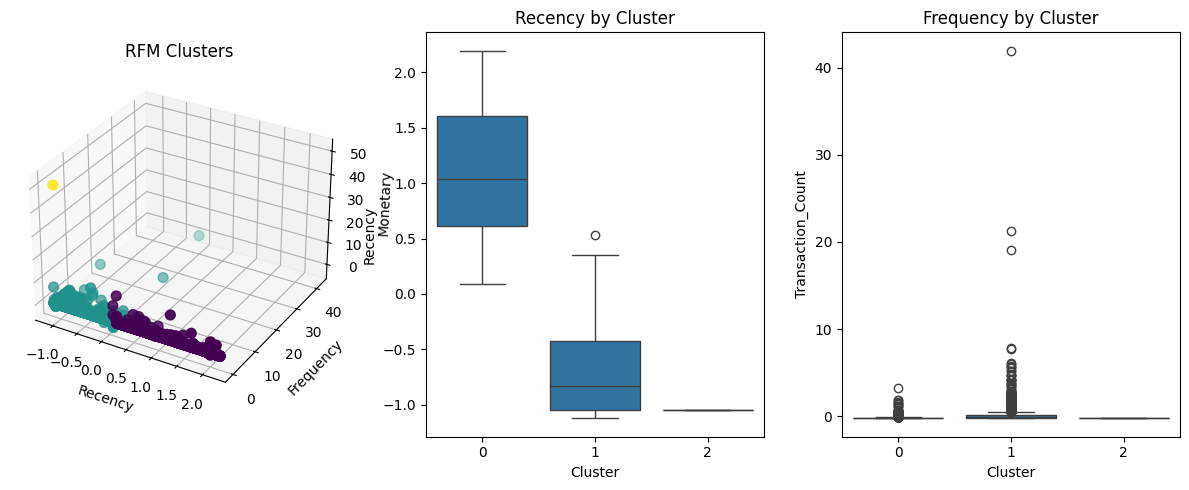

In [6]:
## Step 4: Analyze Clusters to Identify High-Risk Group

print("\n[4/5] Analyzing clusters to identify high-risk group...")

# Create summary statistics by cluster
cluster_summary = df.groupby('Cluster')[required_cols].agg(['mean', 'median', 'count']).round(2)
print("\nCluster Summary (RFM Metrics):")
print(cluster_summary.T)

# Visualize clusters
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(
    df['Recency'], 
    df['Transaction_Count'], 
    df['Average_Transaction_Amount'], 
    c=df['Cluster'], cmap='viridis', s=50
)
ax1.set_xlabel('Recency')
ax1.set_ylabel('Frequency')
ax1.set_zlabel('Monetary')
ax1.set_title('RFM Clusters')

ax2 = fig.add_subplot(132)
sns.boxplot(data=df, x='Cluster', y='Recency')
ax2.set_title('Recency by Cluster')

ax3 = fig.add_subplot(133)
sns.boxplot(data=df, x='Cluster', y='Transaction_Count')
ax3.set_title('Frequency by Cluster')

plt.tight_layout()
plt.show()

In [7]:
# Identify high-risk cluster: typically highest Recency, lowest Frequency & Monetary
# Let's find the cluster with the highest mean Recency and lowest mean Transaction_Count/Average_Transaction_Amount
cluster_metrics = df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Transaction_Count': 'mean',
    'Average_Transaction_Amount': 'mean'
}).reset_index()

# Rank clusters by risk: higher recency + lower frequency + lower monetary = higher risk
cluster_metrics['Risk_Score'] = (
    cluster_metrics['Recency'] / cluster_metrics['Recency'].max() +
    (1 - cluster_metrics['Transaction_Count'] / cluster_metrics['Transaction_Count'].max()) +
    (1 - cluster_metrics['Average_Transaction_Amount'] / cluster_metrics['Average_Transaction_Amount'].max())
)

high_risk_cluster = cluster_metrics.loc[cluster_metrics['Risk_Score'].idxmax(), 'Cluster']

print(f"\nHigh-risk cluster identified: Cluster {int(high_risk_cluster)}")
print("Characteristics:")
print(cluster_metrics[cluster_metrics['Cluster'] == high_risk_cluster].to_string(index=False))


High-risk cluster identified: Cluster 0
Characteristics:
 Cluster  Recency  Transaction_Count  Average_Transaction_Amount  Risk_Score
       0 1.107484          -0.183427                    0.019791    4.582036


In [8]:
## Step 5: Assign Binary Target Variable `is_high_risk`

print("\n[5/5] Creating binary target variable 'is_high_risk'...")

df['is_high_risk'] = (df['Cluster'] == high_risk_cluster).astype(int)

print(f"   Assigned {df['is_high_risk'].sum()} customers as high-risk (1)")
print(f"   Assigned {len(df) - df['is_high_risk'].sum()} customers as low-risk (0)")

# Optional: Drop Cluster column if not needed for modeling
df.drop(columns=['Cluster'], inplace=True, errors='ignore')



[5/5] Creating binary target variable 'is_high_risk'...
   Assigned 1448 customers as high-risk (1)
   Assigned 2294 customers as low-risk (0)


In [9]:
## Step 6: Save Updated Dataset

output_path = '../data/processed/customer_features_with_target.csv'
df.to_csv(output_path, index=False)

print(f"\n✓ Updated dataset saved to: {output_path}")



✓ Updated dataset saved to: ../data/processed/customer_features_with_target.csv
